## Logistic Regression with SGD

To begin you first need to install all dependencies, using:

    pip install -r requirements.txt

In [33]:
import numpy as np
import matplotlib.pyplot as plt

from math import exp, log
import os
import pickle

from skimage import io
from skimage.color import rgb2gray
from skimage.feature import hog

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA

In [34]:
%matplotlib inline

### load the dataset

In [35]:
### set your image dir here
IMAGE_DIR = "./../data/"

In [36]:
def load_dataset(subset="train"):
    """
    1. subset = "train", "val", "test"
    2. About the dataset: in "train","val" subset, the first half of images are images of hands, the rest half are images of not-hand. 
    3. extract features from HoG
    """
    path = os.path.join(IMAGE_DIR,subset)
    name_list = os.listdir(path)
    print("Number of images in {}-set: {}".format(subset, len(name_list)))
    #HoG returns 324 features
    X = np.zeros(shape=(len(name_list), 324))

    if subset == "train" or subset == "val":
        #Make sure that we have equal number of positive and negative class images
        assert len(name_list)%2 == 0
        count = len(name_list)//2
        y = np.array(count*[1] + count*[0])
        for idx_true in range(count):
            img_name = os.path.join(path,str(idx_true)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx_true, :] = vec
        
        for idx in range(count):
            idx_false = idx + count
            img_name = os.path.join(path,str(idx_false)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx_false, :] = vec
        return X, y        
    else:
        for idx in range(len(name_list)):
            img_name = os.path.join(path, str(idx)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx, :] = vec
        return X

### load the data

In [37]:
X_train, y_train = load_dataset("train")
X_val, y_val = load_dataset("val")
X_test = load_dataset("test")

Number of images in train-set: 8170


/usr/local/lib/python2.7/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


Number of images in val-set: 2724
Number of images in test-set: 5542


### displaying images

In [84]:
def display(img_path):
    """
    visualize the img
    """
    img = io.imread(img_path)
    print(img_path)
    io.imshow(img)
    io.show()

./data/train/1.png


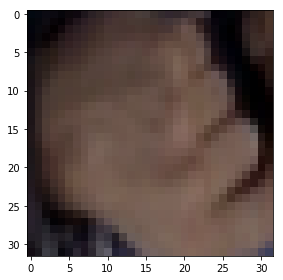

In [85]:
display(IMAGE_DIR+"train/1.png")

In [38]:
y_val.shape = (np.size(y_val),1)
y_train.shape = (np.size(y_train),1)
print X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

(8170, 324) (8170, 1) (2724, 324) (2724, 1) (5542, 324)


### Logistic regression

#### Main function in the class
1. \__init\__() which sets the hyper parameters
2. sigmoid()
3. __init_param(), initializes the parameters .
4. fit(): train the data
5. predict_proba(): predict the probability of the sample belonging to the positive class
6. predict(): classify the sample


Feel free to overlook the rest of the parts of the code, it's just for convenience.


In [39]:
class LogisticRegression:
    """
    Logistic Regression
    """
    def __init__(self, eta0=0.1, eta1=1, m=16, max_epoch=1000, delta=0.0001):
        """
        m is the batch_size
        """
        self.__init = True # whether to initial the parameters
        self.__eta0 = eta0
        self.__eta1 = eta1
        self.__delta = delta
        self.__m = m
        self.__max_epoch = max_epoch
        
    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))
    
    def __init_param(self):
        """
        Weights initialized using a normal distribution here: you can change the distribution.
        """
        d = self.__dimension
        self.__wt = np.random.randn(1,d)
        self.__bias = np.random.randn()
        return self.__wt,self.__bias
    
    
    def compute_loss_function(self, X_data, y_actual):
        card = X_data.shape[0]
        activations = self.predict_proba(X_data)
        Loss_function_c1 = y_actual * np.log(activations)
        Loss_function_c2 = (1.0-y_actual) * (np.log(1.0-activations))
        Loss_function = (-1.0/card)*np.sum(Loss_function_c1 + Loss_function_c2)
        return Loss_function, activations
    
    def compute_accuracy(self, X_data, y_actual):
        predictions = self.predict(X_data)
        correct_predictions = np.sum(y_actual == predictions)*1.0
        acc = correct_predictions/ y_actual.shape[0]
        return acc
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        Recommended input:
        X: n x d array,
        y: n x 1 array or list
        """
        n, d = X.shape
        self.__dimension = d
        
        if self.__init:
            self.__init_param()
        
        ### write your code here ### 

        ############################
        train_loss = []
        val_loss = []
        
        train_acc = []
        val_acc = []
        val_present = 0
        
        if X_val is not None and y_val is not None:
            val_present = 1
        
        for epoch in range(self.__max_epoch):
            # if the loss is not decreasing, we return these previous parameters and ignore the updated 
            previous_weights = self.__wt
            previous_bias = self.__bias
            
            eta = self.__eta0/((self.__eta1*1.0)+epoch)
            
            # permutation
            random_permutation = list(np.random.permutation(n))
            X_shuffled = X[random_permutation,:]
            y_shuffled = y[random_permutation,:].reshape((n,1))
            all_mini_batches = []
            
            remainder = n%self.__m
            quoteint = n//self.__m
            assert quoteint>remainder 
            
            # creating mini-batches of size m
            for idx in range(quoteint-remainder):
                size_m = self.__m
                mini_batch_X = X_shuffled[idx * size_m:(idx + 1) * size_m, :]
                mini_batch_y = y_shuffled[idx * size_m:(idx + 1) * size_m, :]
                mini_batch_idx = (mini_batch_X, mini_batch_y)
                all_mini_batches.append(mini_batch_idx)
            
            # deleting the those which were used above to form mini-batches
            X_shuffled = np.delete(X_shuffled, np.s_[:(quoteint-remainder)*size_m], axis=0)
            y_shuffled = np.delete(y_shuffled, np.s_[:(quoteint-remainder)*size_m], axis=0)
            
            # on the remaining data, form mini_batches of size m+1
            for idx in range(remainder):
                size_mplus1 = self.__m+1
                mini_batch_X = X_shuffled[idx * size_mplus1:(idx + 1) * size_mplus1,:]
                mini_batch_y = y_shuffled[idx * size_mplus1:(idx + 1) * size_mplus1,:]
                mini_batch_idx = (mini_batch_X, mini_batch_y)
                all_mini_batches.append(mini_batch_idx)
            
            # once we have all the data in mini_batches of size m or m+1, we iterate over all these mini_batches
            for idx in range(len(all_mini_batches)):
                mini_batch_X, mini_batch_y = all_mini_batches[idx]
                
                current_mini_batch_size = mini_batch_X.shape[0]
                
                # compute the loss for the minibatch 
                Loss_function, activations = self.compute_loss_function(mini_batch_X, mini_batch_y)
                
                # set the parameter-update-factors as per the derivative of the log probability
                weight_factor = (1.0/current_mini_batch_size)*np.dot((activations-mini_batch_y).T, mini_batch_X)
                bias_factor = (1.0/current_mini_batch_size)*np.sum(activations - mini_batch_y)
                
                # update the parameters
                # since we have class variables self.__wt and self.__bias we would update them directly
                # without having to use different variable theta
                # 
                # and we have previous_weights and previous_bias variables which will provide us with the values
                # of parameters of the previous epoch, even if we incur break in the current epoch
                # 
                # i am not using different variable theta, since we need not have to pass it in predict(),predict_proba() 
                # functions and we could directly use the updated self.__wt and self.__bias in those functions
                self.__wt -= eta*weight_factor
                self.__bias -= eta*bias_factor
            '''
            # training ROC
            fpr, tpr, thresholds = metrics.roc_curve(y, scores
            train_acc.append(train_acc_after_epoch)
            
            # validation ROC
            if val_present>0:
                val_acc_after_epoch = self.compute_accuracy(X_val, y_val)
                val_acc.append(val_acc_after_epoch)
            '''
            # training accuracy
            train_acc_after_epoch = self.compute_accuracy(X, y)
            train_acc.append(train_acc_after_epoch)
            
            # validation accuracy
            if val_present>0:
                val_acc_after_epoch = self.compute_accuracy(X_val, y_val)
                val_acc.append(val_acc_after_epoch)
            
            # training loss
            train_loss_after_epoch,_ = self.compute_loss_function(X, y)
            train_loss.append(train_loss_after_epoch)
            
            # validation loss
            if val_present>0:
                val_loss_after_epoch,_ = self.compute_loss_function(X_val, y_val)
                val_loss.append(val_loss_after_epoch)
                print epoch, " epoch : ", eta, "\t", val_loss_after_epoch, "\t", val_acc_after_epoch, "\t", train_acc_after_epoch
            else:
                print epoch, " epoch : ", eta, "\t", train_loss_after_epoch, "\t", train_acc_after_epoch
            
            # break if loss is not decreasing
            if epoch>0 and epoch<self.__max_epoch-1:
                # if validation data is available, check on this set as well
                if val_present>0:
                    if val_loss[epoch]>(1-self.__delta)*val_loss[epoch-1]:
                        print "Validation Loss not improving...."
                        self.__wt = previous_weights
                        self.__bias = previous_bias
                        return train_loss, val_loss, train_acc, val_acc
                
                if train_loss[epoch]>(1-self.__delta)*train_loss[epoch-1]:
                    print "Training Loss not improving...."
                    self.__wt = previous_weights
                    self.__bias = previous_bias
                    return train_loss, val_loss, train_acc, val_acc
        
        # if loss was decreasing properly, we return after max_epoch iterations
        return train_loss, val_loss, train_acc, val_acc
    
    # since we have class variables self.__wt and self.__bias we would use them instead of 
    # passing around and updating a different variable theta
    def predict_proba(self, X):
        """
        predict the probility of the sample
        You can refer to my code below
        """
        # return a vector containing the probability values of the samples belonging to the positive class
        activations = np.dot(X, (self.__wt).T)+self.__bias
        return self.sigmoid(activations)
    
    def predict(self, X):
        """
        Classify the sample
        """
        # return self.predict_proba(X) >= 0.5 # attention: this will give result in bool, you need to convert it to int for submission. 
        activations = self.predict_proba(X)
        return (activations>=0.5).astype(int)
    
    def get_param(self):
        """
        output:
            parameters: wt(1*d array), b(scalar)
        """
        return [self.__wt, self.__bias]
    
    def save_model(self, save_file):
        """
        save model to .pkl file
        """
        with open(save_file,"wb") as file:
            pickle.dump([self.__wt, self.__bias],file)

    def load_model(self, load_file):
        """
        load model from .pkl file
        """
        with open(load_file,"rb") as file:
            param = pickle.load(file)
        self.__wt = param[0]
        self.__bias = param[1]
        self.__init = False
        return self.__wt, self.__bias

## Question 2.3 - 

### 1. Baseline Model

### Note the last epoch printed below is where we break out of the iterations. Also, if break is encountered, i return the parameters learned in the last but one epoch. if, loop breaks at n th epoch, though i m printing and returning loss and accuracy for this n th epoch also,,, im saving weights self.__wt and self.__bias as they were in the (n-1) th epoch. Intuition - loss is not improving, no use of returning the updated weights, return the weights that were given by the previous epoch.

In [40]:
LR = LogisticRegression()
train_loss, val_loss, train_acc, val_acc = LR.fit(X_train,y_train)

0  epoch :  0.1 	0.6711788489871487 	0.5964504283965728
1  epoch :  0.05 	0.6479422256254431 	0.6392900856793146
2  epoch :  0.0333333333333 	0.6337948419522115 	0.6603427172582619
3  epoch :  0.025 	0.6239384487690945 	0.6791921664626683
4  epoch :  0.02 	0.6164794233880069 	0.6925336597307221
5  epoch :  0.0166666666667 	0.6105111659954866 	0.6990208078335374
6  epoch :  0.0142857142857 	0.6055443674009422 	0.7063647490820073
7  epoch :  0.0125 	0.6013273359404567 	0.7155446756425948
8  epoch :  0.0111111111111 	0.5976880754483869 	0.7216646266829866
9  epoch :  0.01 	0.5944719803871882 	0.7253365973072216
10  epoch :  0.00909090909091 	0.5916131845132718 	0.7296205630354957
11  epoch :  0.00833333333333 	0.5890426316879032 	0.7348837209302326
12  epoch :  0.00769230769231 	0.5867023799885754 	0.7380660954712362
13  epoch :  0.00714285714286 	0.584562664815795 	0.7402692778457772
14  epoch :  0.00666666666667 	0.5825935761644881 	0.7423500611995104
15  epoch :  0.00625 	0.58077294631

121  epoch :  0.000819672131148 	0.5324969024944557 	0.7882496940024479
122  epoch :  0.000813008130081 	0.5323341645070203 	0.7883720930232558
123  epoch :  0.000806451612903 	0.5321729737348456 	0.7883720930232558
124  epoch :  0.0008 	0.5320132984687849 	0.7884944920440636
125  epoch :  0.000793650793651 	0.5318551021022522 	0.7887392900856793
126  epoch :  0.000787401574803 	0.5316983080798935 	0.788984088127295
127  epoch :  0.00078125 	0.5315429755293233 	0.7891064871481028
128  epoch :  0.00077519379845 	0.531389037589805 	0.7891064871481028
129  epoch :  0.000769230769231 	0.5312364924224764 	0.7894736842105263
130  epoch :  0.000763358778626 	0.5310853165438223 	0.7894736842105263
131  epoch :  0.000757575757576 	0.5309354931083442 	0.7895960832313341
132  epoch :  0.000751879699248 	0.5307869548774481 	0.7895960832313341
133  epoch :  0.000746268656716 	0.530639719451296 	0.789718482252142
134  epoch :  0.000740740740741 	0.5304937622570173 	0.7899632802937576
135  epoch :  0

240  epoch :  0.000414937759336 	0.5196369779693825 	0.7988984088127294
241  epoch :  0.000413223140496 	0.5195629345278087 	0.7988984088127294
242  epoch :  0.000411522633745 	0.5194892483077206 	0.7988984088127294
243  epoch :  0.000409836065574 	0.5194159120756335 	0.7988984088127294
244  epoch :  0.000408163265306 	0.5193429175525527 	0.7988984088127294
245  epoch :  0.000406504065041 	0.5192702787896218 	0.7988984088127294
246  epoch :  0.000404858299595 	0.5191979787094286 	0.7990208078335373
247  epoch :  0.000403225806452 	0.5191260051720611 	0.7990208078335373
248  epoch :  0.000401606425703 	0.5190543736459656 	0.7991432068543451
249  epoch :  0.0004 	0.5189830902341676 	0.7991432068543451
250  epoch :  0.000398406374502 	0.5189121156019622 	0.799265605875153
251  epoch :  0.000396825396825 	0.5188414762114162 	0.7993880048959608
252  epoch :  0.000395256916996 	0.5187711637093501 	0.7995104039167686
253  epoch :  0.000393700787402 	0.5187011658272438 	0.7996328029375765
254 

(a) Number of epochs till termination = 301

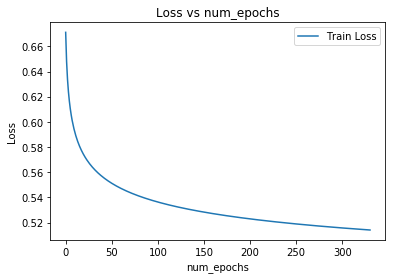

In [41]:
# (b) Plot L(theta) vs num_epochs
plt.plot(train_loss[:-1])
plt.xlabel("num_epochs")
plt.ylabel("Loss")
plt.title("Loss vs num_epochs")
plt.legend(['Train Loss'], loc='upper right')
plt.savefig("q2_3_1_baseline.png")
plt.show()

(c) Final value of L($\theta$) after optimization = 0.5026397259571352

### 2. Experimenting with ($\eta_0$,$\eta_1$)

### increasing eta1, will decrease our learning rate eta (of course there is eta0 and epoch terms as well in eta) But the intuition here is that increasing eta1 will decrease eta. Smaller learning rate means gradient descent will take very small small steps towards the minima and take more time to converge. 

### Question 2.3.2 clearly mentions to Keep m = 16, δ = 0.0001 and just change eta0 and eta1 in an attempt to converge faster. Here, nothing is mentioned in the question about converging faster to the best solution or converging faster to the baseline loss obtained in the previous cell.

### converging faster to the best solution is not possible by just tweaking eta0 and eta1. So im solving this question considering converging faster than the above cell. And im interpreting faster convergence means lesser number of epochs it took to reach the loss as obtained above.

### also it is no where mentioned in question 2.3.2 to use validation data. So i m calling fit() with simple xtrain and ytrain and not using validation for this part.

In [43]:
LR2 = LogisticRegression(eta0=1.0, eta1=0.1)
train_loss2, val_loss2, train_acc2, val_acc2 = LR2.fit(X_train, y_train)

0  epoch :  10.0 	0.3453802213035193 	0.8521419828641371
1  epoch :  0.909090909091 	0.2970108254911712 	0.8778457772337821
2  epoch :  0.47619047619 	0.29304307042590777 	0.8829865361077112
3  epoch :  0.322580645161 	0.2922769320297716 	0.8820073439412485
4  epoch :  0.243902439024 	0.29159530571503545 	0.8835985312117504
5  epoch :  0.196078431373 	0.291057158343351 	0.8842105263157894
6  epoch :  0.16393442623 	0.2909894226911532 	0.8821297429620563
7  epoch :  0.140845070423 	0.29060883715926417 	0.8851897184822521
8  epoch :  0.123456790123 	0.29029782777087465 	0.8826193390452877
9  epoch :  0.10989010989 	0.2902809063899909 	0.8817625458996328
Training Loss not improving....


(a) Best value for, $\eta_0$ = 1.0, $\eta_1$ = 0.1

Number of epochs for training = 10

Final value of L($\theta$) = 0.2890968784617844

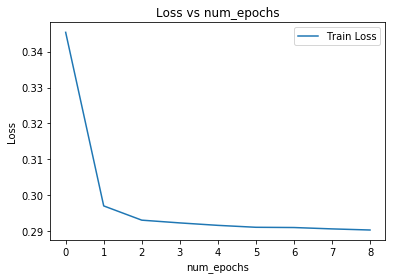

In [44]:
# (b) For best (eta_0, eta_1) plot L(theta) vs num_epochs
plt.plot(train_loss2[:-1])
plt.xlabel("num_epochs")
plt.ylabel("Loss")
plt.title("Loss vs num_epochs")
plt.legend(['Train Loss'], loc='upper right')
plt.savefig('q2_3_2_best_eta.png')
plt.show()

### 3. Evaluating on validation set

## Note that either of the L on train or val (if present) is not improving, we break

#### in this question, since there is no constraint mentioned on the hyperparameters, i m assuming its to be done for baseline as done in 2.3.1 for all default values of hyperparameters

In [45]:
LR2 = LogisticRegression()
train_loss2, val_loss2, train_acc2, val_acc2 = LR2.fit(X_train, y_train, X_val, y_val)


0  epoch :  0.1 	0.6821344730684802 	0.5730543318649045 	0.5738066095471236
1  epoch :  0.05 	0.6567078545660414 	0.6336270190895742 	0.6299877600979192
2  epoch :  0.0333333333333 	0.6410912623254047 	0.6696035242290749 	0.6679314565483476
3  epoch :  0.025 	0.6305929796681603 	0.6890602055800293 	0.6843329253365973
4  epoch :  0.02 	0.6224692315896964 	0.7030102790014684 	0.7012239902080784
5  epoch :  0.0166666666667 	0.6161961338867411 	0.7110866372980911 	0.7079559363525092
6  epoch :  0.0142857142857 	0.6107994533487315 	0.7217327459618208 	0.7215422276621787
7  epoch :  0.0125 	0.6062669679735626 	0.7287077826725403 	0.7274173806609547
8  epoch :  0.0111111111111 	0.6024011225299352 	0.736784140969163 	0.7334149326805386
9  epoch :  0.01 	0.5990176350856864 	0.7415565345080763 	0.738922888616891
10  epoch :  0.00909090909091 	0.5959309091703204 	0.7514684287812041 	0.7423500611995104
11  epoch :  0.00833333333333 	0.5931970446661762 	0.7529368575624082 	0.7460220318237454
12  ep

95  epoch :  0.00104166666667 	0.5391878997461892 	0.8076358296622613 	0.7974296205630355
96  epoch :  0.00103092783505 	0.5389649064226586 	0.8076358296622613 	0.7973072215422277
97  epoch :  0.00102040816327 	0.5387449910561244 	0.8076358296622613 	0.7974296205630355
98  epoch :  0.0010101010101 	0.5385280014153169 	0.8072687224669604 	0.7974296205630355
99  epoch :  0.001 	0.5383137171558298 	0.8076358296622613 	0.7974296205630355
100  epoch :  0.000990099009901 	0.5381015360212212 	0.8080029368575624 	0.7975520195838434
101  epoch :  0.000980392156863 	0.5378911822072691 	0.8080029368575624 	0.7976744186046512
102  epoch :  0.000970873786408 	0.5376845197070108 	0.8087371512481645 	0.7976744186046512
103  epoch :  0.000961538461538 	0.5374798131094035 	0.8087371512481645 	0.7976744186046512
104  epoch :  0.000952380952381 	0.5372777877159423 	0.8087371512481645 	0.797796817625459
105  epoch :  0.000943396226415 	0.5370776902543043 	0.8087371512481645 	0.7979192166462669
106  epoch 

186  epoch :  0.000534759358289 	0.5256491190802413 	0.8190161527165932 	0.8050183598531212
187  epoch :  0.000531914893617 	0.5255469744041463 	0.8193832599118943 	0.805140758873929
188  epoch :  0.000529100529101 	0.5254451899803492 	0.8193832599118943 	0.8050183598531212
189  epoch :  0.000526315789474 	0.5253440879357731 	0.8193832599118943 	0.805140758873929
190  epoch :  0.000523560209424 	0.5252437529359173 	0.8193832599118943 	0.8053855569155447
191  epoch :  0.000520833333333 	0.5251440702685449 	0.8193832599118943 	0.8053855569155447
192  epoch :  0.000518134715026 	0.5250448368788367 	0.8193832599118943 	0.8053855569155447
193  epoch :  0.000515463917526 	0.5249463533012204 	0.8193832599118943 	0.8056303549571603
194  epoch :  0.000512820512821 	0.5248483437400577 	0.8193832599118943 	0.8056303549571603
195  epoch :  0.000510204081633 	0.524750906876714 	0.8193832599118943 	0.8056303549571603
196  epoch :  0.000507614213198 	0.5246542546790256 	0.8193832599118943 	0.80563035

278  epoch :  0.000358422939068 	0.5182170861515777 	0.8212187958883994 	0.8091799265605876
279  epoch :  0.000357142857143 	0.5181527784430345 	0.8212187958883994 	0.8091799265605876
280  epoch :  0.000355871886121 	0.5180887547557096 	0.8215859030837004 	0.8091799265605876
281  epoch :  0.000354609929078 	0.5180249587457707 	0.8215859030837004 	0.8093023255813954
282  epoch :  0.000353356890459 	0.5179615638558958 	0.8215859030837004 	0.8093023255813954
283  epoch :  0.000352112676056 	0.5178982666168936 	0.8215859030837004 	0.8093023255813954
284  epoch :  0.000350877192982 	0.517835341451896 	0.8215859030837004 	0.8093023255813954
285  epoch :  0.00034965034965 	0.5177726235661928 	0.8215859030837004 	0.8091799265605876
286  epoch :  0.000348432055749 	0.5177101275598832 	0.8215859030837004 	0.8093023255813954
287  epoch :  0.000347222222222 	0.517647882244579 	0.8215859030837004 	0.8093023255813954
288  epoch :  0.000346020761246 	0.5175858368230822 	0.8215859030837004 	0.80930232

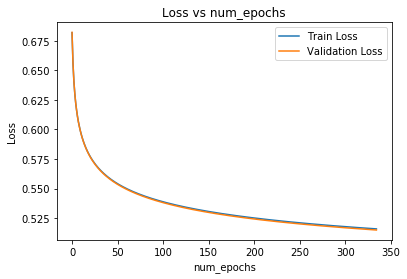

In [46]:
# (a) Plot L(theta) vs num_epochs for both training and validation set on the same figure

plt.plot(train_loss2[:-1])
plt.plot(val_loss2[:-1])
plt.xlabel("num_epochs")
plt.ylabel("Loss")
plt.title("Loss vs num_epochs")
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.savefig('q2_3_3loss.png')
plt.show()

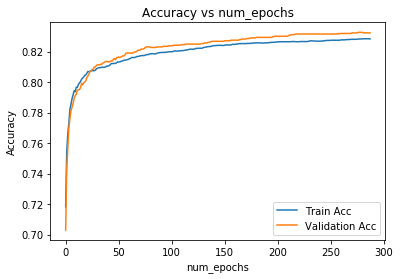

In [109]:
# (b) Plot Accuracy vs num_epochs for both training and validation set on the same figure
plt.plot(train_acc2[:-1])
plt.plot(val_acc2[:-1])
plt.xlabel("num_epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs num_epochs")
plt.legend(['Train Acc', 'Validation Acc'], loc='lower right')
plt.savefig('q2_3_3acc.png')
plt.show()

### 4. ROC and Precision-Recall curves

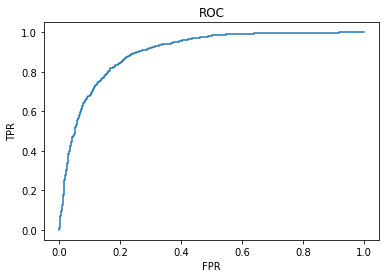

AUC: 0.9007969622283891


In [47]:
#(a) Plot ROC curve on validation data
yvalpred = LR2.predict_proba(X_val)
fpr, tpr, thresholds = roc_curve(y_val, yvalpred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.savefig('auc.png')
plt.show()
print "AUC:" ,roc_auc


Area under curve = 0.9079380327366898

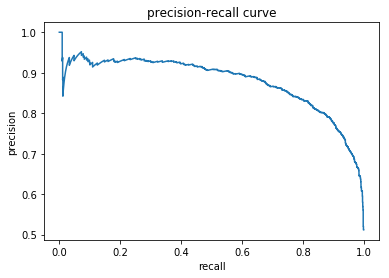

0.8788363254627485


In [48]:
#(a) Plot Precision-Recall curve on validation data
average_precision = average_precision_score(y_val, yvalpred)
precision, recall, _ = precision_recall_curve(y_val, yvalpred)
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision-recall curve')
plt.show()
print average_precision

Average Precision = 0.8856957237420138

# Question 2.4

### two major changes i made are as follows - 
### 1. block_norm='L2-Hys' : 
#### I m going to use this while extracting HoG features while loading the dataset
### 2. He initialization for weights : 
#### instead of starting from random numbers for weights, i start with random but normalized weights. to normalise i use sqrt(2/d) where d is number of features.

### 3. PCA : 
#### after extracting 324 features for each image, I applied PCA with n_components 50, 100, 150, 200 to reduce the dimensionality of our feature vector. But they didnot give beter results. So im not including them in my results here

In [7]:
def load_dataset2(subset="train"):
    """
    1. subset = "train", "val", "test"
    2. About the dataset: in "train","val" subset, the first half of images are images of hands, the rest half are images of not-hand. 
    3. extract features from HoG
    """
    path = os.path.join(IMAGE_DIR,subset)
    name_list = os.listdir(path)
    print("Number of images in {}-set: {}".format(subset, len(name_list)))
    #HoG returns 324 features
    X = np.zeros(shape=(len(name_list), 324))
    #pca = PCA(n_components=200)
    
    if subset == "train" or subset == "val":
        #Make sure that we have equal number of positive and negative class images
        assert len(name_list)%2 == 0
        count = len(name_list)//2
        y = np.array(count*[1] + count*[0])
        for idx_true in range(count):
            img_name = os.path.join(path,str(idx_true)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img, block_norm='L2-Hys')
            X[idx_true, :] = vec
        
        for idx in range(count):
            idx_false = idx + count
            img_name = os.path.join(path,str(idx_false)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img, block_norm='L2-Hys')
            X[idx_false, :] = vec
        #X1 = pca.fit_transform(X)
        return X, y        
    else:
        for idx in range(len(name_list)):
            img_name = os.path.join(path, str(idx)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img, block_norm='L2-Hys')
            X[idx, :] = vec
        #X1 = pca.fit_transform(X)
        return X

In [8]:
X_train2, y_train2 = load_dataset2("train")
X_val2, y_val2 = load_dataset2("val")
X_test2 = load_dataset2("test")

y_val2.shape = (np.size(y_val2),1)
y_train2.shape = (np.size(y_train2),1)
print X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape

Number of images in train-set: 8170
Number of images in val-set: 2724
Number of images in test-set: 5542
(8170, 324) (8170, 1) (2724, 324) (2724, 1) (5542, 324)


In [9]:
class LogisticRegression2:
    """
    Logistic Regression
    """
    def __init__(self, eta0=0.1, eta1=1, m=16, max_epoch=1000, delta=0.0001):
        """
        m is the batch_size
        """
        self.__init = True # whether to initial the parameters
        self.__eta0 = eta0
        self.__eta1 = eta1
        self.__delta = delta
        self.__m = m
        self.__max_epoch = max_epoch
        
    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))
    
    def __init_param(self):
        """
        Weights initialized using a normal distribution here: you can change the distribution.
        """
        d = self.__dimension
        self.__wt = np.random.randn(1,d)
        self.__bias = np.random.randn()
        return self.__wt,self.__bias
    
    def __he_init_param(self):
        """
        Weights initialized using a normal distribution here: you can change the distribution.
        """
        d = self.__dimension
        self.__wt = np.random.randn(1,d)**np.sqrt(2/d)
        self.__bias = np.random.randn()
        return self.__wt,self.__bias
    
    def compute_loss_function(self, X_data, y_actual):
        card = X_data.shape[0]
        activations = self.predict_proba(X_data)
        Loss_function_c1 = y_actual * np.log(activations)
        Loss_function_c2 = (1.0-y_actual) * (np.log(1.0-activations))
        Loss_function = (-1.0/card)*np.sum(Loss_function_c1 + Loss_function_c2)
        return Loss_function, activations
    
    def compute_accuracy(self, X_data, y_actual):
        predictions = self.predict(X_data)
        correct_predictions = np.sum(y_actual == predictions)*1.0
        acc = correct_predictions/ y_actual.shape[0]
        return acc
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        Recommended input:
        X: n x d array,
        y: n x 1 array or list
        """
        n, d = X.shape
        self.__dimension = d
        
        if self.__init:
            self.__he_init_param()
        
        ### write your code here ### 

        ############################
        train_loss = []
        val_loss = []
        
        train_acc = []
        val_acc = []
        val_present = 0
        
        y.shape = (np.size(y),1)
        
        if X_val is not None and y_val is not None:
            val_present = 1
            y_val.shape = (np.size(y_val),1)
        
        for epoch in range(self.__max_epoch):
            previous_weights = self.__wt
            previous_bias = self.__bias
            eta = self.__eta0/((self.__eta1*1.0)+epoch)
            random_permutation = list(np.random.permutation(n))
            X_shuffled = X[random_permutation,:]
            y_shuffled = y[random_permutation,:].reshape((n,1))
            all_mini_batches = []
            
            remainder = n%self.__m
            quoteint = n//self.__m
            assert quoteint>remainder 
            
            for idx in range(quoteint-remainder):
                size_m = self.__m
                mini_batch_X = X_shuffled[idx * size_m:(idx + 1) * size_m, :]
                mini_batch_y = y_shuffled[idx * size_m:(idx + 1) * size_m, :]
                mini_batch_idx = (mini_batch_X, mini_batch_y)
                all_mini_batches.append(mini_batch_idx)
            
            X_shuffled = np.delete(X_shuffled, np.s_[:(quoteint-remainder)*size_m], axis=0)
            y_shuffled = np.delete(y_shuffled, np.s_[:(quoteint-remainder)*size_m], axis=0)
            
            for idx in range(remainder):
                size_mplus1 = self.__m+1
                mini_batch_X = X_shuffled[idx * size_mplus1:(idx + 1) * size_mplus1,:]
                mini_batch_y = y_shuffled[idx * size_mplus1:(idx + 1) * size_mplus1,:]
                mini_batch_idx = (mini_batch_X, mini_batch_y)
                all_mini_batches.append(mini_batch_idx)
            
            for idx in range(len(all_mini_batches)):
                mini_batch_X, mini_batch_y = all_mini_batches[idx]
                
                current_mini_batch_size = mini_batch_X.shape[0]
                
                Loss_function, activations = self.compute_loss_function(mini_batch_X, mini_batch_y)
                weight_factor = (1.0/current_mini_batch_size)*np.dot((activations-mini_batch_y).T, mini_batch_X)
                bias_factor = (1.0/current_mini_batch_size)*np.sum(activations - mini_batch_y)
                
                self.__wt -= eta*weight_factor
                self.__bias -= eta*bias_factor

            # training accuracy
            train_acc_after_epoch = self.compute_accuracy(X, y)
            train_acc.append(train_acc_after_epoch)
            
            # validation accuracy
            if val_present>0:
                val_acc_after_epoch = self.compute_accuracy(X_val, y_val)
                val_acc.append(val_acc_after_epoch)
            
            # training loss
            train_loss_after_epoch,_ = self.compute_loss_function(X, y)
            train_loss.append(train_loss_after_epoch)
            
            # validation loss
            if val_present>0:
                val_loss_after_epoch,_ = self.compute_loss_function(X_val, y_val)
                val_loss.append(val_loss_after_epoch)
                print epoch, " epoch : ", eta, "\t", val_loss_after_epoch, "\t", val_acc_after_epoch, "\t", train_acc_after_epoch
            else:
                print epoch, " epoch : ", eta, "\t", train_loss_after_epoch, "\t", train_acc_after_epoch
            
            # break if loss is increasing more
            if epoch>0 and epoch<self.__max_epoch-1:
                if val_present>0:
                    if val_loss[epoch]>(1-self.__delta)*val_loss[epoch-1]:
                        print "Validation Loss not improving...."
                        self.__wt = previous_weights
                        self.__bias = previous_bias
                        return train_loss, val_loss, train_acc, val_acc
                
                if train_loss[epoch]>(1-self.__delta)*train_loss[epoch-1]:
                    print "Training Loss not improving...."
                    self.__wt = previous_weights
                    self.__bias = previous_bias
                    return train_loss, val_loss, train_acc, val_acc
        return train_loss, val_loss, train_acc, val_acc
    
    def predict_proba(self, X):
        """
        predict the probility of the sample
        You can refer to my code below
        """
        # return a vector containing the probability values of the samples belonging to the positive class
        activations = np.dot(X, (self.__wt).T)+self.__bias
        return self.sigmoid(activations)
    
    def predict(self, X):
        """
        Classify the sample
        """
        # return self.predict_proba(X) >= 0.5 # attention: this will give result in bool, you need to convert it to int for submission. 
        activations = self.predict_proba(X)
        return (activations>=0.5).astype(int)
    
    def get_param(self):
        """
        output:
            parameters: wt(1*d array), b(scalar)
        """
        return [self.__wt, self.__bias]
    
    def save_model(self, save_file):
        """
        save model to .pkl file
        """
        with open(save_file,"wb") as file:
            pickle.dump([self.__wt, self.__bias],file)

    def load_model(self, load_file):
        """
        load model from .pkl file
        """
        with open(load_file,"rb") as file:
            param = pickle.load(file)
        self.__wt = param[0]
        self.__bias = param[1]
        self.__init = False
        return self.__wt, self.__bias

In [27]:
# Experimentation code goes here
# LR2 = LogisticRegression2(eta0=1.0, eta1=100.0,m=4, delta=0.0000001, max_epoch=15000) only on train
# LR2 = LogisticRegression2(eta0=1.0, eta1=10.0,m=8  , delta=0.000001, max_epoch=15000) 0.287151; 0.8839941 only on train
# LR2 = LogisticRegression2(eta0=1.0, eta1=1000.0,m=8  , delta=0.01) 0.50703 only on train
#LR2 = LogisticRegression2(eta0=1.0, eta1=120.0, m=1, delta=0.0000001) #0.89 only on train
# LR2 = LogisticRegression2(eta0=1.0, eta1=7.4, m=2) # 0.89390 only on train
#LR2 = LogisticRegression2(eta0=1.0, eta1=2.4, m=3) only on train
#LR2 = LogisticRegression2(eta0=1.0, eta1=3.4, m=3) # 0.89390 only on train
# LR3 = LogisticRegression2(eta0=1.0, eta1=24.4, m=1) only on train
#LR3 = LogisticRegression2(eta0=1.0, eta1=9.4, m=3) 

LR3 = LogisticRegression2(eta0=1.0, eta1=7.4, m=2) # both train+val 0.895 best

print "epoch \t\t learning rate \t\t loss \t\t accuracy"
train_loss3, val_loss3, train_acc3, val_acc3 = LR3.fit(np.vstack((X_train2,X_val2)), 
                                                       np.vstack((y_train2, y_val2)), X_val2, y_val2)

#train_loss2, val_loss2, train_acc2, val_acc2 = LR2.fit(X_train, y_train, X_val, y_val)

epoch 		 learning rate 		 loss 		 accuracy
0  epoch :  0.135135135135 	0.2747632966908726 	0.8755506607929515 	0.8819533688268771
1  epoch :  0.119047619048 	0.2510710587044537 	0.8913362701908958 	0.8952634477694144
2  epoch :  0.106382978723 	0.24083411186091455 	0.8961086637298091 	0.8990269873324765
3  epoch :  0.0961538461538 	0.23640973170998902 	0.8990455212922174 	0.8993023682761153
4  epoch :  0.0877192982456 	0.23337498401220041 	0.9023494860499266 	0.9027905268955388
5  epoch :  0.0806451612903 	0.2320874518016884 	0.9056534508076358 	0.905727923627685
6  epoch :  0.0746268656716 	0.2303233101107719 	0.9038179148311307 	0.9055443363319259
7  epoch :  0.0694444444444 	0.23173556630124806 	0.9023494860499266 	0.9018725904167432
Validation Loss not improving....


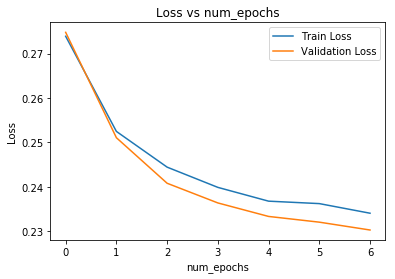

In [28]:
plt.plot(train_loss3[:-1])
plt.plot(val_loss3[:-1])
plt.xlabel("num_epochs")
plt.ylabel("Loss")
plt.title("Loss vs num_epochs")
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.savefig('q2_4_loss.png')
plt.show()

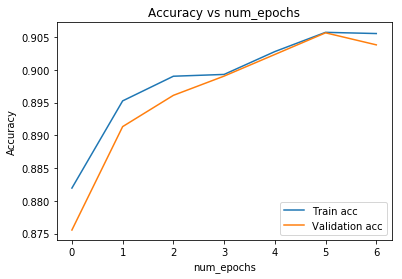

In [29]:
plt.plot(train_acc3[:-1])
plt.plot(val_acc3[:-1])
plt.xlabel("num_epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs num_epochs")
plt.legend(['Train acc', 'Validation acc'], loc='lower right')
plt.savefig('q2_4_acc.png')
plt.show()

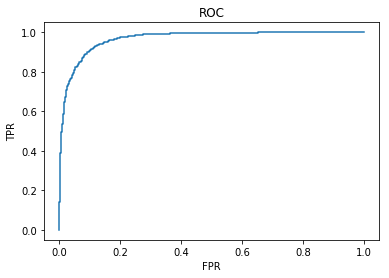

AUC: 0.9674934934157895


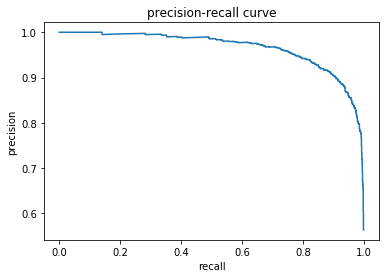

AP: 0.9656369481933269


In [30]:
#(a) Plot ROC curve on validation data
yvalpred = LR3.predict_proba(X_val2)
fpr, tpr, thresholds = roc_curve(y_val2, yvalpred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.savefig('q2_4_auc.png')
plt.show()
print "AUC:" ,roc_auc

#(a) Plot Precision-Recall curve on validation data
average_precision = average_precision_score(y_val2, yvalpred)
precision, recall, _ = precision_recall_curve(y_val2, yvalpred)
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision-recall curve')
plt.savefig('q2_4_ap.png')
plt.show()
print "AP:", average_precision

## Question 2.4

### 1. Submission

In [31]:
import pandas as pd
def submission(y_pred):
    """
    generate the submission.csv for kaggle
    input args:
        y_pred: 5542x1 array or list contains 5542 elements
        
    """
    save_file = pd.DataFrame(columns=["Id","Class"])
    id = np.array([idx for idx in range(5542)])
    save_file["Id"] = id
    save_file["Class"]= y_pred
    save_file.to_csv("submission.csv",index=0)       

#### Generate the submission.csv

In [32]:
# code goes here
ypred = LR3.predict(X_test2)
print ypred.shape
submission(ypred)

(5542, 1)


Best obtained accuracy on Public Leader-board = 0.89534